In [16]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st


import itertools

2) Discrete Event Simulation

In [2]:
def Queue(env, n_persons, average_arrival_time, servers, waiting_times_list, prints):
    """queue gets customers randomly"""
    for i in range(n_persons):
        person = Person(env, f'Person {i:02d}', servers, waiting_times_list, prints)
        env.process(person)
        arrival_time = random.expovariate(1.0 / average_arrival_time) # Markov?
        yield env.timeout(arrival_time)

def Person(env, name, servers, waiting_times_list, prints, average_serving_time=10):
    """People arrive, wait in queue, are served and leaves."""
    arrive = env.now
    if prints:
        print(f'{arrive:7.4f} {name} arrived')

    with servers.request() as req:
        # Wait for a server
        yield req 

        wait = env.now - arrive
        waiting_times_list.append(wait)
        if prints:
            print(f'{env.now:7.4f} {name} waited {wait:6.3f}')


        serving_time = random.expovariate(1.0 / average_serving_time)
        yield env.timeout(serving_time)
        if prints:
            print(f'{env.now:7.4f} {name} left')  

def run_simulation(average_arrival_rate, n, mu, n_persons, waiting_times_list, print=False):
    env = simpy.Environment()

    # Start
    servers = simpy.Resource(env, capacity=n*mu)
    env.process(Queue(env, n_persons, average_arrival_rate, servers, waiting_times_list, print))
    env.run()

    # Print the list of waiting times
    return waiting_times_list


System load 1 server: 5.0
System load 2 servers: 2.5
System load 4 servers: 1.25


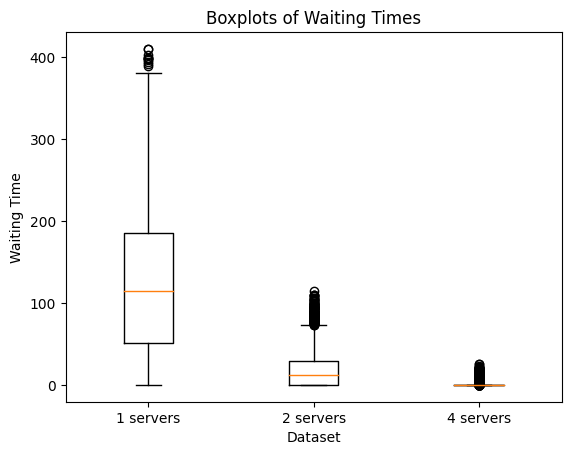

In [38]:
np.random.seed(3)

# λ – the arrival rate into the system as a whole.
# interval customers
arrival_rate = 5

# μ – the capacity of each of n equal servers. 
mu = 1

# ρ represents the system load. ρ=λ/(n*capacity). 
print(f"System load 1 server: {arrival_rate/(1*mu)}")
print(f"System load 2 servers: {arrival_rate/(2*mu)}")
print(f"System load 4 servers: {arrival_rate/(4*mu)}")

# Number of people in simulation and the number of days tested:
n_persons = 50
runs = 100

# Waiting times
waiting_times_n1 = []
waiting_times_n2 = []
waiting_times_n4 = []


for run in range(runs):
    run_simulation(arrival_rate, 1, mu, n_persons, waiting_times_n1)
    run_simulation(arrival_rate, 2, mu, n_persons, waiting_times_n2)
    run_simulation(arrival_rate, 4, mu, n_persons, waiting_times_n4)


# Create positions for boxplots
positions = [1, 2, 3]
# Create a boxplot
plt.boxplot([waiting_times_n1,waiting_times_n2,waiting_times_n4], positions=positions)
plt.title('Boxplots of Waiting Times')
plt.xlabel('Dataset')
plt.ylabel('Waiting Time')
plt.xticks(positions, ['1 servers', '2 servers', '4 servers'])

# Show the plot
plt.show()

In [39]:
print(f"For a queue with in total {n_persons} people that get in the queue with an interval of approximately {arrival_rate} seconds for {runs} days:")
print(f"the mean waiting time was {np.mean(waiting_times_n1)}, with a standard deviation of {np.std(waiting_times_n1)}")
print(f"the mean waiting time was {np.mean(waiting_times_n2)}, with a standard deviation of {np.std(waiting_times_n2)}")
print(f"the mean waiting time was {np.mean(waiting_times_n4)}, with a standard deviation of {np.std(waiting_times_n4)}")


For a queue with in total 50 people that get in the queue with an interval of approximately 5 seconds for 100 days:
the mean waiting time was 123.20928234295691, with a standard deviation of 86.45306237214638
the mean waiting time was 19.329078045492647, with a standard deviation of 22.107020634927586
the mean waiting time was 0.7836243059222369, with a standard deviation of 2.5989277223005667


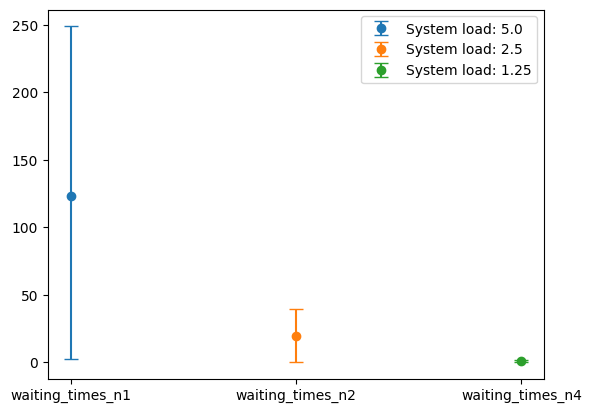

In [46]:
def plot_conf_95(waiting_times):
    mean = np.mean(waiting_times)
    
    confidence_interval =st.t.interval(confidence=0.95, df=len(waiting_times)-1, loc=mean, scale=st.sem(waiting_times))
    yerr = np.array([[confidence_interval[0], confidence_interval[1]]])
    return mean, yerr

m1, yerr1 = plot_conf_95(waiting_times_n1)
m2, yerr2 = plot_conf_95(waiting_times_n2)
m4, yerr4 = plot_conf_95(waiting_times_n4)

plt.errorbar(x='waiting_times_n1', y=m1, yerr=yerr1.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(1*mu)}")
plt.errorbar(x='waiting_times_n2', y=m2, yerr=yerr2.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(2*mu)}")
plt.errorbar(x='waiting_times_n4', y=m4, yerr=yerr4.T, fmt='o', capsize=5, label=f"System load: {arrival_rate/(4*mu)}")
plt.legend()
plt.show()
